# An EOF analysis of AO 

This notebook collects my work of Arctic Oscillation patterns and how atmospheric/surface ocean conditions correspond with different AO phases.

* Update 2016/01/08 Datasets are now coherent with Xianmin's modelling work.
* Update 2016/01/20 Speed up the code, move some calculations to `_/script/Anomaly_Calculations.py`

# Content
1. [**Import modules & tools**](#Import-modules-&-tools)
1. [**EOF modes & AO Index**](#EOF-modes-&-AO-Index)
  2. [EOF results](#EOF-results)
  2. [Get top 5% min/max](#Get-top-5%-min/max)
1. [**Anomaly combinations**](#Anomaly-combinations)
  2. [Surface atmospheric patterns](#Surface-atmospheric-patterns)
  2. [Surface ocean conditions](#Surface-ocean-conditions)

# Import modules & tools

In [1]:
import sys
sys.path.insert(0, '_libs/')
import NEMO_tools as Nts

In [2]:
import glob
import datetime
import scipy.io
import scipy.signal
import numpy as np
import netCDF4 as nc
import cartopy.feature
import cartopy.crs as ccrs # ccrs
#import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

In [3]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran

In [4]:
def EOF(H, nmode=10, ndim=3, reverse=1):
    '''
    Converted from MATLAB to Python 2.7 code @ 2015/06/15 - YKS
     + ndim: [LAT, LON, TIME] data (=3) or [MAP, TIME] data (=2)
     + reverse: normalized spatial pattern (=0), normalized PC (=1)
    % ======================================================================= %
    % Input
    %   H: Variable required for EOF comutation, H(LAT, LON, Time) 
    %       or H(Space, Time) is accepted.
    %   nmode: Number of modes output
    % Output
    %   EOFs: EOF Spatial Pattern
    %   PC: Timeseries cooresponding to each EOFs
    %   expvar: Explained variance
    % ======================================================================= %
    % Author
    %   Yingkai Sha
    %       yingkaisha@gmail.com
    % 2014/3/18
    % ======================================================================= %
    '''
    ##import scipy.linalg.eig as eig
    # Get the size of array
    if ndim == 3:
        LAT, LON, T = H.shape
    elif ndim == 2:
        LON, T = H.shape
        LAT = 1
    # Covarience
    H = np.reshape(H, [LAT*LON, T]).T
    R=np.dot(H, H.T); N = np.size(R, 0)
    # Allocation
    PC     = np.zeros([nmode, T]);
    expvar = np.zeros([nmode]);
    eof    = np.zeros([N, LAT*LON]);
    EOFs   = np.zeros([LAT, LON, nmode]);
    # Eigvector analysis
    L, E = np.linalg.eig(R)
    # Get modes
    E    = np.dot(H.T, E)
    #sq   = (np.sqrt(np.diag(L))).T
    #sq   = sq[0, :]
    sq = np.sqrt(L)
    E    = E/sq
    Z    = np.dot(E.T, H.T)
    for i in range(nmode):
        eof[i, :] = np.squeeze(E[:, i]).T
        PC[i, :]  = np.squeeze(Z[i, :])
    # Get expvar
    L = np.abs(L)
    dsum = np.sum(np.abs(L))
    # Output
    for i in range(nmode):
        expvar[i] = L[i]/dsum
        EOFs[:, :, i] = np.reshape(eof[i, :], [LAT, LON])
    if reverse==1:
        EOFs, PC = reverse_std(EOFs, PC, nmode)
    return EOFs, PC, expvar

def reverse_std(EOFs, PC, nmode):
    for i in range(nmode):
        STD = np.nanstd(PC[i, :])
        PC[i, :] = PC[i, :]/STD
        EOFs[:, :, i] = EOFs[:, :, i]*STD
    return EOFs, PC

In [5]:
def seasonal_decomp3d(data, method=0):
    '''
    =======================================================================
    Remove the seasonal cycle from 1D data
                            ----- created on 2015/06/15, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        data = seasonal_decomp(...)
    -----------------------------------------------------------------------
    Input:
            data: Time should be the first dim.
            method: removal done by anomaly (=0) or normalize (=1)
    ======================================================================= 
    '''
    for mon in range(12):
        temp_data = np.nanmean(data[mon:len(data):12, :, :], 0)
        if method == 0:
            data[mon:len(data):12, :, :] = data[mon:len(data):12, :, :]-temp_data
    return data

# EOF modes & AO Index

data: CMC-GDPS (The one runs ANHA4-EXH001)
* Sea level pressure

In [6]:
year = np.arange(2002, 2014)
slp = np.empty([144, 368, 801])
for i in range(12):
    name = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*slp*'+str(year[i])+'*monmean*')
    slp_obj = nc.Dataset(name[0])
    slp[i*12:(i+1)*12, :, :] = slp_obj.variables['atmpres'][:, :, :]

In [7]:
x = slp_obj.variables['LON'][:]
y = slp_obj.variables['LAT'][:]
[lon, lat] = np.meshgrid(x, y)

In [8]:
slp = seasonal_decomp3d(slp, method=0)
slp = np.transpose(slp, [1, 2, 0])
slp_np = slp[y>20, :, :]
lon_np = lon[y>20, :]
lat_np = lat[y>20, :]

In [9]:
EOFs, PC, expvar = EOF(slp_np, nmode=10, ndim=3, reverse=1)
EOFs = EOFs/100.0 # Pa to hPa
# Convert negative AO spatial pattern to positive
EOFs[:, :, 0] = -1*EOFs[:, :, 0]
PC[0, :] = -1*PC[0, :]

/home/yingkai/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/yingkai/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:48: ComplexWarning: Casting complex values to real discards the imaginary part


## EOF results

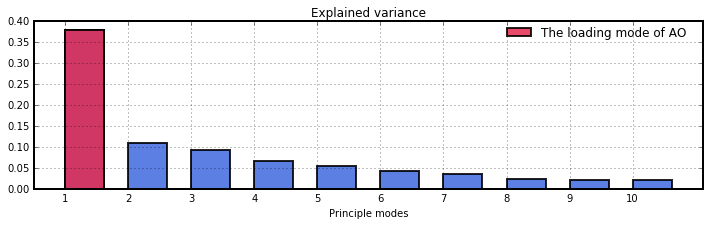

In [10]:
fig=plt.figure(figsize=(12, 3))
ax=plt.gca(); ax.grid(); ax.set_xlim(0.5, 11.118)
ax.bar(np.arange(1, 11), expvar, width=0.618, lw=2, alpha=0.85, color=RB)
ax.bar(1, expvar[0], width=0.618, lw=2, alpha=0.85, color=AM, label='The loading mode of AO')
ax.set_xticks(np.arange(1, 11))
LG = ax.legend(numpoints=1, bbox_to_anchor=(0.7, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
[i.set_linewidth(2) for i in ax.spines.itervalues()]
ax.set_xlabel('Principle modes')
ax.set_title('Explained variance', fontsize=12)

In [11]:
def draw_smode(lon, lat, EOFs, clevs, num, ax, edge=0):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=20, lon_0=90, round=True, ax=ax)
    proj.drawparallels(np.arange(0, 90, 20), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    CS = proj.contourf(x, y, EOFs[:, :, num], clevs, cmap=plt.cm.RdBu_r, extend='both')
    proj.contour(x, y, EOFs[:, :, num], clevs, colors='gray', linewidths=1.5)
    if edge == 1:
        proj.contour(x, y, EOFs[:, :, num], [-0.5, 0.5], colors='k', linewidths=2.5)
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    #ax.text(0.75, 0.90, "Exp. var.: %.2f"%expvar[num], transform=ax.transAxes, \
        #fontsize=10, verticalalignment='top', bbox=props)
    return CS

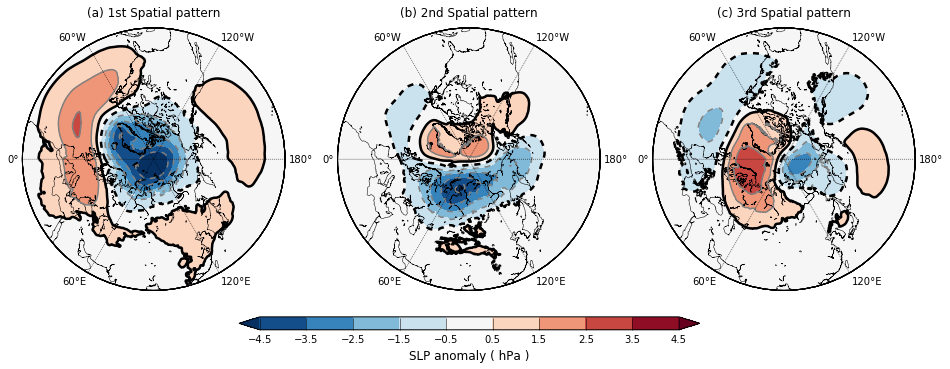

In [12]:
clevs = np.arange(-4.5, 5.5, 1)
#
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((1, 3), (0, 2), colspan=1, rowspan=1)
#ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
#
CS = draw_smode(lon_np, lat_np, EOFs, clevs, 0, ax1, edge=1)
ax1.set_title('(a) 1st Spatial pattern', y=1.025)
draw_smode(lon_np, lat_np, EOFs, clevs, 1, ax2, edge=1)
ax2.set_title('(b) 2nd Spatial pattern', y=1.025)
draw_smode(lon_np, lat_np, EOFs, clevs, 2, ax3, edge=1)
ax3.set_title('(c) 3rd Spatial pattern', y=1.025)
#draw_smode(lon_np, lat_np, EOFs, clevs, 3, ax4)
#ax4.set_title('(d) 4th Spatial pattern', y=1.025)
# bottom colorbar
cax  = fig.add_axes([0.313, 0.315, 0.4, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('SLP anomaly ( hPa )', fontsize=12)
CBar.ax.tick_params(axis='x', length=12)
CBar.set_ticks(clevs)

Comparing with **NCEP-NCAR Reanalysis**

<img src="_figures/NCEP_AO.png" width=700 align="left"/>

## Get top 5% min/max

In [13]:
T = PC[0, :]
ag_num = 7 # top 5%
# ===================================================================================== #
upper_ind = np.argpartition(T, -1*ag_num)[-1*ag_num:] # largest
lower_ind = np.argpartition(-1*T, -1*ag_num)[-1*ag_num:] # lowest
var_upper = np.empty(T.shape); var_upper[:] = np.nan; var_upper[upper_ind]=T[upper_ind]
var_lower = np.empty(T.shape); var_lower[:] = np.nan; var_lower[lower_ind]=T[lower_ind]
#
upper_bound = np.nanmin(var_upper)
lower_bound = np.nanmax(var_lower)

In [14]:
from dateutil.relativedelta import relativedelta

In [15]:
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(len(PC[0, :]))]

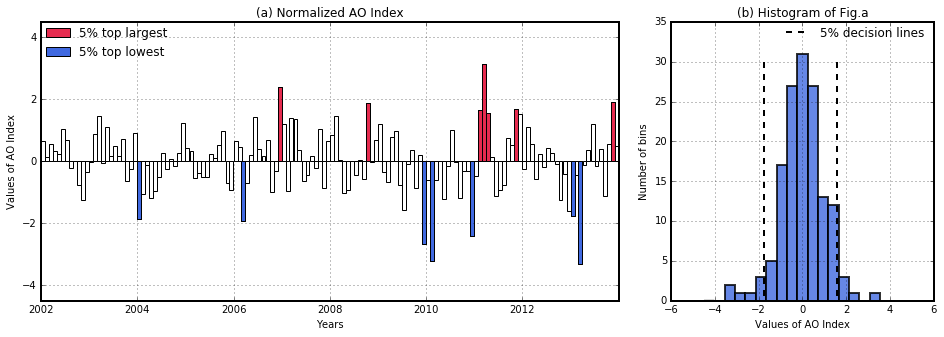

In [16]:
fig = plt.figure(figsize=(16, 5))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((1, 3), (0, 2), colspan=1, rowspan=1)
ax1.grid(); ax2.grid()
#
ax1.bar(date_list, PC[0, :], width=30, color='w', lw=1)
ax1.bar(date_list, var_upper, width=30, color=AM, label='5% top largest')
ax1.bar(date_list, var_lower, width=30, color=RB, label='5% top lowest')
LG = ax1.legend(numpoints=1, bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
[i.set_linewidth(2) for i in ax1.spines.itervalues()]
ax1.set_title('(a) Normalized AO Index')
ax1.set_xlabel('Years')
ax1.set_ylabel('Values of AO Index')
ax1.set_ylim(-4.5, 4.5)
#
ax2.hist(PC[0, :], np.linspace(-4.5, 4.5, 20), color=RB, lw=2, alpha=0.8);
ax2.plot([upper_bound, upper_bound], [30, 0], 'k--', lw=2, label='5% decision lines')
ax2.plot([lower_bound, lower_bound], [30, 0], 'k--', lw=2)
LG = ax2.legend(numpoints=1, bbox_to_anchor=(0.42, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
[i.set_linewidth(2) for i in ax2.spines.itervalues()]
ax2.set_xlabel('Values of AO Index')
ax2.set_ylabel('Number of bins')
ax2.set_title('(b) Histogram of Fig.a')

In [17]:
save_var = {'AO_index':T, 'upper_index':upper_ind, 'lower_index':lower_ind}
scipy.io.savemat('_data/Exchange/AO_inds.mat', mdict=save_var)

# Anomaly combinations

In [18]:
MAT=scipy.io.loadmat('_data/Exchange/anomaly_for_AO.mat')
u10 = MAT['u10'][:]
v10 = MAT['v10'][:]
slp = MAT['slp'][:]/100 # Pa --> hPa
#zc = MAT['zonalc'][:]
#mc = MAT['meridc'][:]
#ssh = MAT['ssh'] [:]

In [19]:
#obj_h = nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc')
#ssh = obj_h.variables['sossheig'][:]
#ssh[ssh>100] = np.nan
#ssha = seasonal_decomp3d(ssh)
obj_z = nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/vozocrtx_monmean.nc')
obj_m = nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/vomecrty_monmean.nc')
obj_h = nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc')

zc = obj_z.variables['vozocrtx'][:]
zc[zc>100] = np.nan
zca = seasonal_decomp3d(zc)

mc = obj_m.variables['vomecrty'][:]
mc[mc>100] = np.nan
mca = seasonal_decomp3d(mc)

ssh = obj_h.variables['sossheig'][:]
ssh[ssh>100] = np.nan
ssha = seasonal_decomp3d(ssh)

/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


## Surface atmospheric patterns

In [20]:
x = slp_obj.variables['LON'][:]
y = slp_obj.variables['LAT'][:]
[lon, lat] = np.meshgrid(x, y)

In [21]:
upper_u10 = np.empty([ag_num, 368, 801])
upper_v10 = np.empty([ag_num, 368, 801])
lower_u10 = np.empty([ag_num, 368, 801])
lower_v10 = np.empty([ag_num, 368, 801])
upper_slp = np.empty([ag_num, 368, 801])
lower_slp = np.empty([ag_num, 368, 801])

for i in range(ag_num):
    upper_u10[i, :, :]   = u10[upper_ind[i], :, :]
    upper_v10[i, :, :]   = v10[upper_ind[i], :, :]
    upper_slp[i, :, :]   = slp[upper_ind[i], :, :]
    lower_u10[i, :, :]   = u10[lower_ind[i], :, :]
    lower_v10[i, :, :]   = v10[lower_ind[i], :, :]
    lower_slp[i, :, :]   = slp[lower_ind[i], :, :]

upper_u10_mean = np.mean(upper_u10, 0)
upper_v10_mean = np.mean(upper_v10, 0)
lower_u10_mean = np.mean(lower_u10, 0)
lower_v10_mean = np.mean(lower_v10, 0)
upper_slp_mean = np.mean(upper_slp, 0)
lower_slp_mean = np.mean(lower_slp, 0)

In [22]:
### Cannot plot streamlines under "projection='npstere'" ?
#import numpy as np
#import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
##
#x0 = np.linspace(-180, 180, 100)
#y0 = np.linspace(-90, 90, 50)
#lon, lat = np.meshgrid(x0, y0)
#u = lon**2+lat**2
#v = lon**2-lat**2
##
#proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=90, round=True, area_thresh=5e4, ax=ax)
#proj.drawparallels(np.arange(0, 90, 20), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
#proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
#proj.drawcoastlines(linewidth=0.5, color='k')
#x, y = proj(lon, lat)
#proj.streamplot(x, y, u, v)
##plt.streamplot(x, y, u, v)

In [23]:
def draw_wind(lon, lat, u, v, ax):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=90, round=True, ax=ax)
    proj.drawparallels(np.arange(0, 90, 20), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    Q=proj.quiver(x, y, u, v, color=[0.25, 0.25, 0.25], width=0.003, scale=50)
    #plt.streamplot(x, y, u, v)
    Qlabel=plt.quiverkey(Q, 0.1, 0.9, 0.01, '0.01 m/s', labelpos='W')
    return CS
def draw_slp(lon, lat, slp, clevs, ax):
    #ax2 = plt.subplot(1, 2, 2, projection=ccrs.NorthPolarStereo(), sharex=ax1, sharey=ax1)
    proj=Basemap(projection='npstere', resolution='l', boundinglat=20, lon_0=90, round=True, ax=ax)
    proj.drawparallels(np.arange(0, 90, 20), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    #proj.fillcontinents(color='coral', zorder=4)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    CS = proj.contourf(x, y, slp, clevs, cmap=plt.cm.RdBu_r, extend='both')
    proj.contour(x, y, slp, clevs, colors='gray', linewidths=1.5)
    return CS

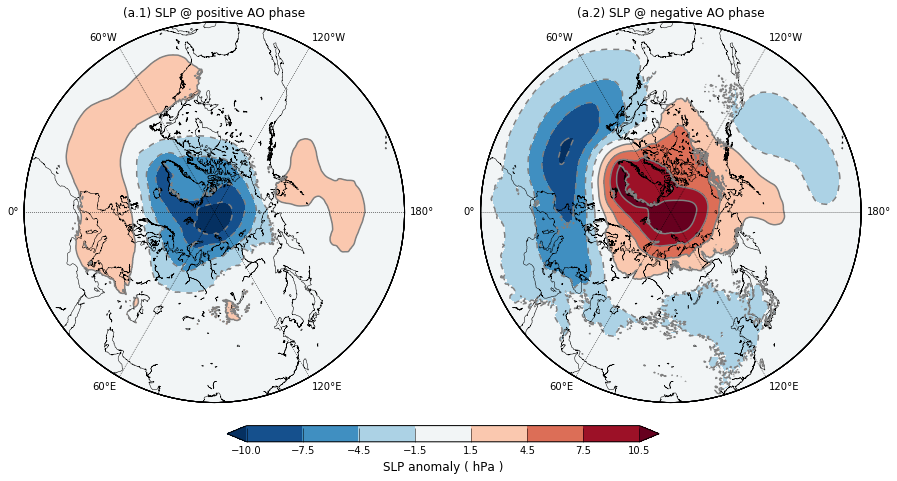

In [24]:
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

ax1.set_title('(a.1) SLP @ positive AO phase')
ax2.set_title('(a.2) SLP @ negative AO phase')

clevs = [-10, -7.5, -4.5, -1.5, 1.5, 4.5, 7.5, 10.5]

CS = draw_slp(lon, lat, upper_slp_mean, clevs, ax1)
draw_slp(lon, lat, lower_slp_mean, clevs, ax2)

cax  = fig.add_axes([0.313, 0.3, 0.4, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('SLP anomaly ( hPa )', fontsize=12)
CBar.ax.tick_params(axis='x', length=14)
CBar.set_ticks(clevs)

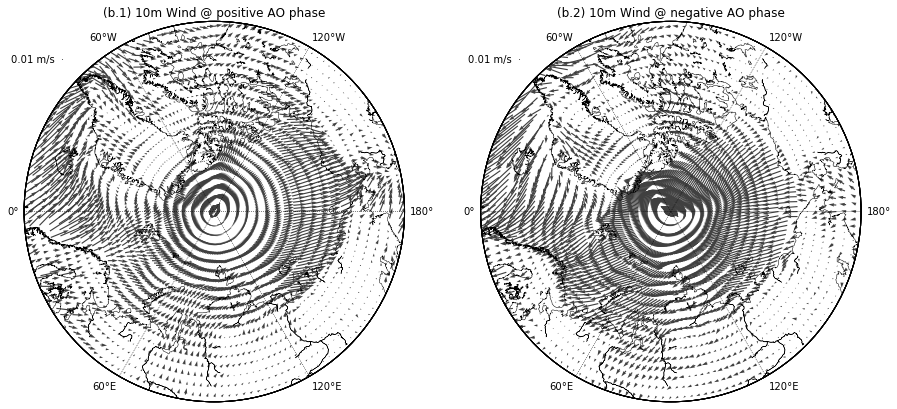

In [25]:
delx = 5; dely = 5

fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

ax1.set_title('(b.1) 10m Wind @ positive AO phase')
ax2.set_title('(b.2) 10m Wind @ negative AO phase')

draw_wind(lon[::delx, ::dely], lat[::delx, ::dely], upper_u10_mean[::delx, ::dely], upper_v10_mean[::delx, ::dely], ax1)
draw_wind(lon[::delx, ::dely], lat[::delx, ::dely], lower_u10_mean[::delx, ::dely], lower_v10_mean[::delx, ::dely], ax2)

## Surface ocean conditions

In [27]:
ptrc_obj = nc.Dataset('/ocean/yingkai/GEOTRACES/Simulations/run/GEOTRACES_1m_20020101_20131231_ptrc_T.nc')
nav_lat=ptrc_obj.variables['nav_lat'][:]
nav_lon=ptrc_obj.variables['nav_lon'][:]

In [28]:
upper_u = np.empty([ag_num, 800, 544])
upper_v = np.empty([ag_num, 800, 544])
lower_u = np.empty([ag_num, 800, 544])
lower_v = np.empty([ag_num, 800, 544])
upper_ssh = np.empty([ag_num, 800, 544])
lower_ssh = np.empty([ag_num, 800, 544]) 

for i in range(ag_num):
    upper_u  [i, :, :] = zc [upper_ind[i], :, :]
    upper_v  [i, :, :] = mc [upper_ind[i], :, :]
    upper_ssh[i, :, :] = ssh[upper_ind[i], :, :]
    lower_u  [i, :, :] = zc [lower_ind[i], :, :]
    lower_v  [i, :, :] = mc [lower_ind[i], :, :]
    lower_ssh[i, :, :] = ssh[lower_ind[i], :, :]
    
upper_u_mean = np.nanmean(upper_u, 0)
upper_v_mean = np.nanmean(upper_v, 0)
lower_u_mean = np.nanmean(lower_u, 0)
lower_v_mean = np.nanmean(lower_v, 0)
upper_ssh_mean = np.nanmean(upper_ssh, 0)
lower_ssh_mean = np.nanmean(lower_ssh, 0)

In [29]:
obj_h.variables['sossheig'][:].shape

(144, 800, 544)

In [36]:
def draw_currents(lon, lat, u, v, ax):
    proj=Basemap(projection='npstere', resolution='i', boundinglat=60, lon_0=90, round=True, ax=ax)
    proj.drawparallels(np.arange(0, 90, 20), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    Q=proj.quiver(x, y, u, v, color=[0.25, 0.25, 0.25], width=0.0015, scale=1.1)
    Qlabel=plt.quiverkey(Q, 0.1, 0.9, 0.1, '0.1 m/s', labelpos='W')
    return CS
def draw_ssh(lon, lat, ssh, clevs, ax):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=90, round=True, ax=ax)
    proj.drawparallels(np.arange(0, 90, 20), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    #proj.fillcontinents(color='coral', zorder=4)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    CS = proj.contourf(x, y, ssh, clevs, cmap=plt.cm.RdBu_r, extend='both')
    #proj.contour(x, y, slp, clevs, colors='gray', linewidths=1.5)
    return CS

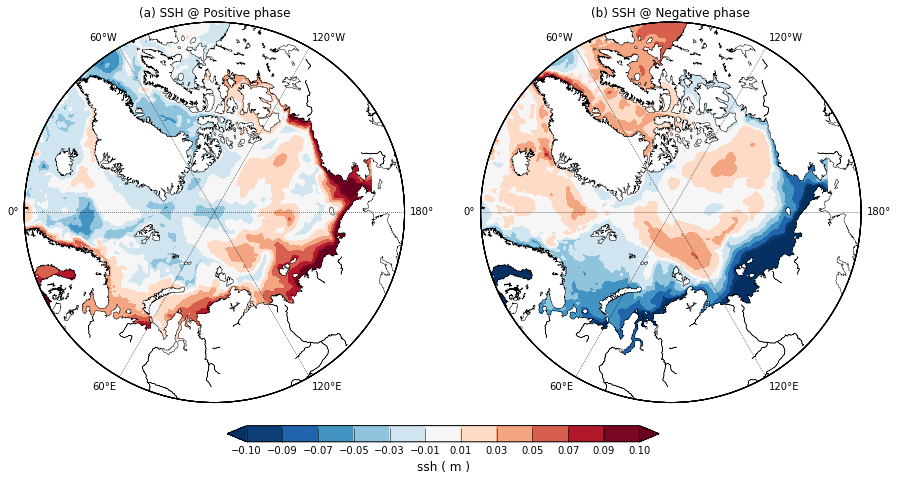

In [31]:
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

ax1.set_title('(a) SSH @ Positive phase')
ax2.set_title('(b) SSH @ Negative phase')

clevs = [-0.1, -0.09, -0.07, -0.05, -0.03, -0.01, 0.01, 0.03, 0.05, 0.07, 0.09, 0.1]

CS = draw_ssh(nav_lon, nav_lat, upper_ssh_mean, clevs, ax1)
draw_ssh(nav_lon, nav_lat, lower_ssh_mean, clevs, ax2)

cax  = fig.add_axes([0.313, 0.3, 0.4, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('ssh ( m )', fontsize=12)
CBar.ax.tick_params(axis='x', length=14)
CBar.set_ticks(clevs)

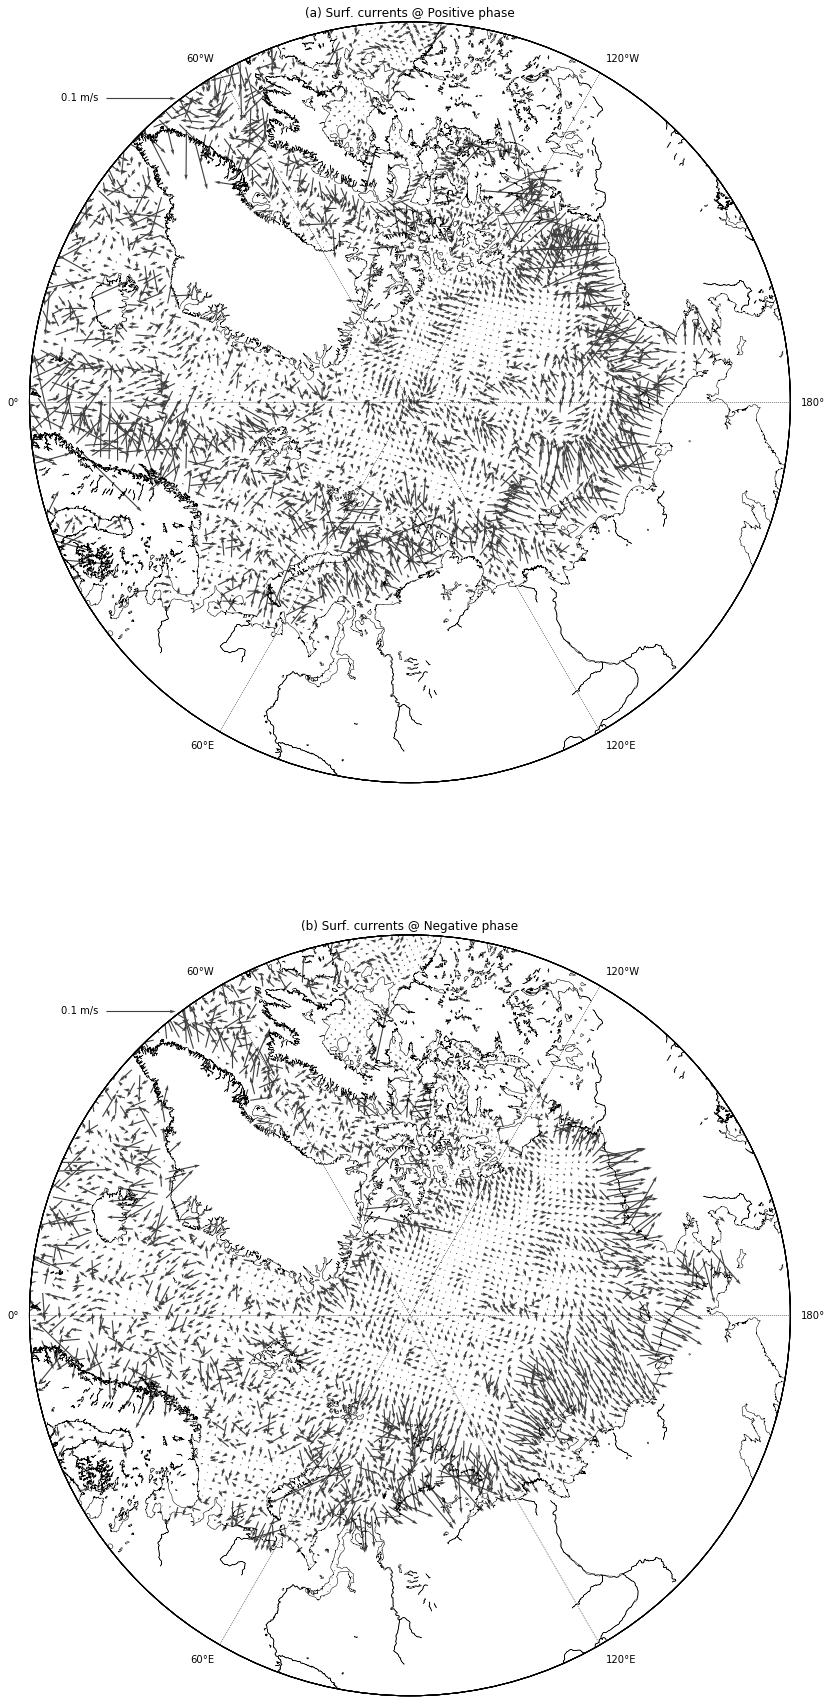

In [37]:
gapx=5; gapy=5

fig = plt.figure(figsize=(30 , 30))
ax1 = plt.subplot2grid((2, 1), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((2, 1), (1, 0), colspan=1, rowspan=1)

ax1.set_title('(a) Surf. currents @ Positive phase')
ax2.set_title('(b) Surf. currents @ Negative phase')

draw_currents(nav_lon[::gapy, ::gapx], nav_lat[::gapy, ::gapx], upper_u_mean[::gapy, ::gapx], upper_v_mean[::gapy, ::gapx], ax1)
draw_currents(nav_lon[::gapy, ::gapx], nav_lat[::gapy, ::gapx], lower_u_mean[::gapy, ::gapx], lower_v_mean[::gapy, ::gapx], ax2)